# Stochastic Gradient Descent
***

In this assignment we'll implement a rudimentary Stochastic Gradient Descent algorithm to learn the weights in simple linear regression.  Then we'll see if we can make it more efficient.  Finally, we'll investigate some graphical strategies for diagnosing convergence and tuning parameters. 

**Note**: The cell below has some helper functions.  Scroll down and evaluate those before proceeding. 

In [6]:
import numpy as np 
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as plt 
import pytest
%matplotlib inline

In [3]:
mycolors = {"blue": "steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke": "#f2f2f2"}

def eval_RSS(X, y, b0, b1):
    rss = 0 
    for ii in range(len(df)):
        xi = df.loc[ii, "x"]
        yi = df.loc[ii, "y"]
        rss += (yi - (b0 + b1 * xi)) ** 2
    return rss

def plotsurface(X, y, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1]) ** 2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0, y1], color="black", marker="o", lw=1.5, markersize=5)

### Part 1: Setting Up Simulated Data and a Sanity Check 
***

We'll work with simulated data for this exercise where our generative model is given by 

$$
Y = 1 + 2X + \epsilon \textrm{ where} \epsilon \sim N(0, \sigma^2)
$$

**Part A**: The following function will generate data from the model. We'll grab a training set of size $n=100$ and a validation set of size $n = 50$.  

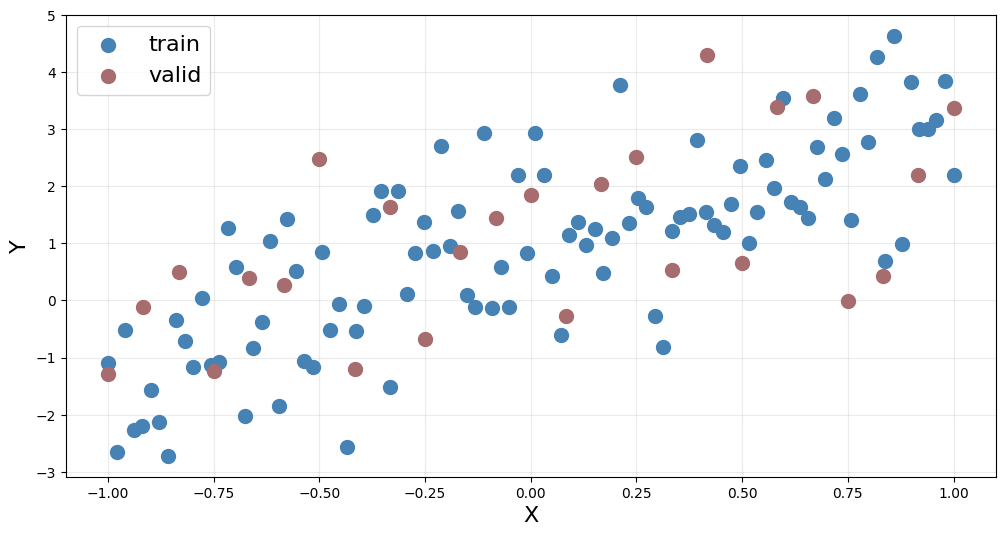

In [4]:
def dataGenerator(n, sigsq=1.0, random_state=1236):
    np.random.seed(random_state)
    x_train = np.linspace(-1, 1, n)
    x_valid = np.linspace(-1, 1, int(n / 4))
    y_train = 1 + 2 * x_train + np.random.randn(n)
    y_valid = 1 + 2 * x_valid + np.random.randn(int(n / 4))
    return x_train, x_valid, y_train, y_valid 

x_train, x_valid, y_train, y_valid = dataGenerator(100)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(x_train, y_train, color="steelblue", s=100, label="train")
ax.scatter(x_valid, y_valid, color="#a76c6e", s=100, label="valid")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.legend(loc="upper left", fontsize=16)

**Part B**: Since we're going to be implementing things ourselves, we're going to want to prepend the data matrices with a column of ones so we can fit a bias term.  We can do this using numpy's [column_stack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.column_stack.html) function. 

In [5]:
X_train = np.column_stack((np.ones_like(x_train), x_train))
X_valid = np.column_stack((np.ones_like(x_valid), x_valid))

**Part C**: Finally, let's fit a linear regression model with sklearn's LinearRegression class and print the coefficients so we know what we're shooting for. 

In [7]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)
print("sklearn says the coefficients are ", reg.coef_)

sklearn says the coefficients are  [0.90918343 2.20093262]


**Part D**: The last thing we'll do is visualize the surface of the RSS, of which we're attempting to find the minimum. Does it looks like the parameters reported by sklearn lie at the bottom of the RSS surface?  

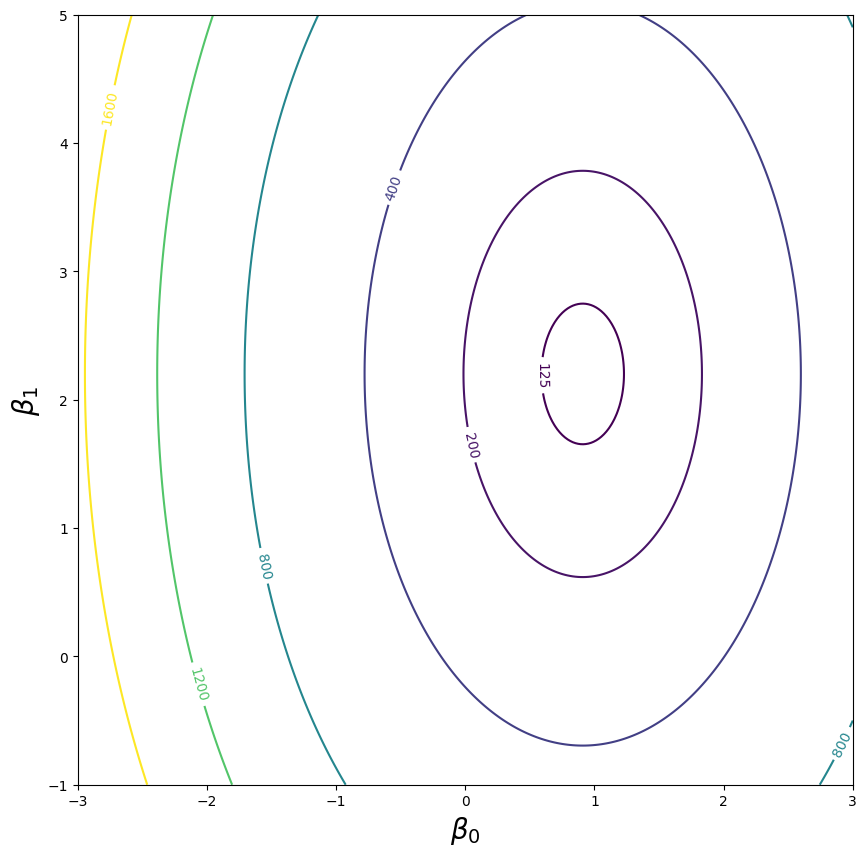

In [8]:
plotsurface(X_train, y_train)

### Part 2: Implementing and Improving SGD 
***

**Part A**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 


\begin{align*}
\beta_0 &\leftarrow \beta_0 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] \\
\beta_1 &\leftarrow \beta_1 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] x_i\\
\end{align*}


Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting and diagnostic purposes. <br>
Look at the Peer Review assignment for a question about this section. 

In [34]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform steps for all epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices (randomly)
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # TODO: loop over training examples, update beta (beta[0] and beta[1]) as per the above formulas
        # your code here
        for i in shuffled_inds:
            factor = eta * 2 * (sum(beta * X[i])-y[i])
            beta[0] -= factor
            beta[1] -= factor * X[i,1]
        
        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

In [35]:
# SGD Test for 2 features
np.random.seed(42)

mock_X = np.array([[ 1., -1.], [ 1., -0.97979798], [ 1., -0.95959596], [ 1., -0.93939394]])
mock_y = np.array([-1.09375848, -2.65894663, -0.51463485, -2.27442244])
mock_beta_start = np.array([-2.0, -1.0])

mock_bhist_exp = np.array([[-2., -1.], [-2.01174521, -0.98867152], [-2.02304238, -0.97777761], [-2.03400439, -0.96720934]])
mock_bhist_act = sgd(mock_X, mock_y, beta=mock_beta_start, eta=0.0025, num_epochs=3)

for exp, act in zip(mock_bhist_exp, mock_bhist_act):
    assert pytest.approx(exp, 0.0001) == act, "Check sgd function"

CPU times: total: 234 ms
Wall time: 223 ms
beta_0 = 0.91899, beta_1 = 2.20488


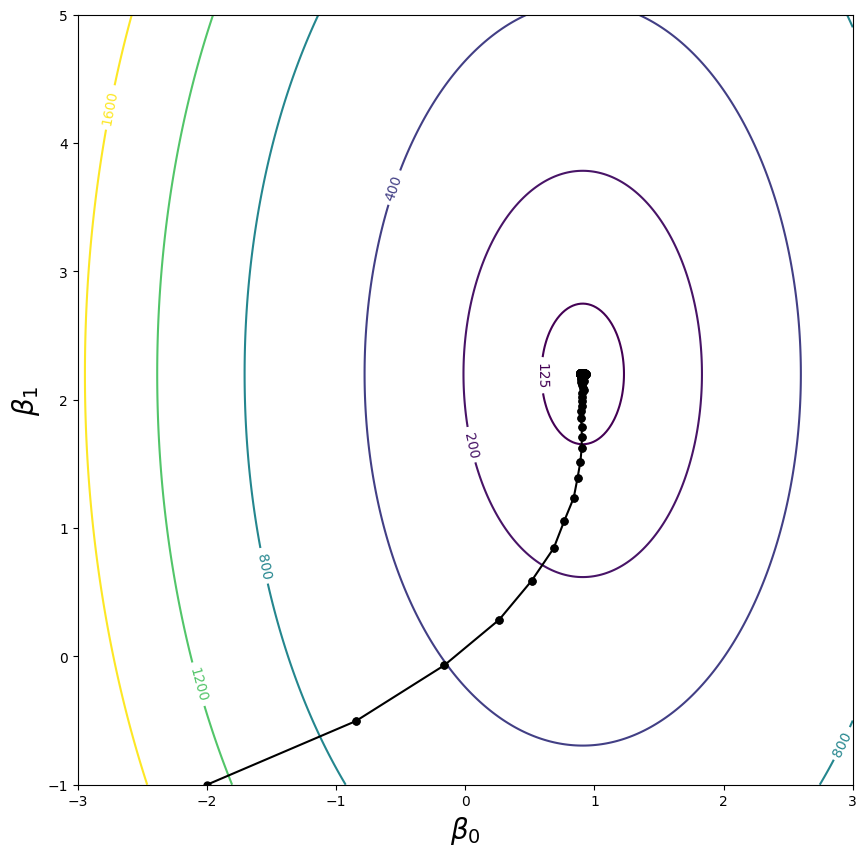

In [36]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000) # old = 0.0025

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part B**: Thinking about the case where we have more than two features, can you think of a way to vectorize the stochastic gradient update of the parameters? When you see it, go back to the sgd function and improve it. 

In [37]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0, :] = beta
    
    # perform epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices 
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # loop over training examples 
        for index in shuffled_inds:
            diff = np.dot(beta, X[index, :]) - y[index]
            beta = beta - eta * 2 * diff * X[index, :]

        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

In [38]:
# SGD Test for more than 2 features
np.random.seed(42)

mock_X = np.array([[ 1., -1.], [ 1., -0.97979798], [ 1., -0.95959596], [ 1., -0.93939394]])
mock_y = np.array([-1.09375848, -2.65894663, -0.51463485, -2.27442244])
mock_beta_start = np.array([-2.0, -1.0])

mock_bhist_exp = np.array([[-2., -1.], [-2.01174521, -0.98867152], [-2.02304238, -0.97777761], [-2.03400439, -0.96720934]])
mock_bhist_act = sgd(mock_X, mock_y, beta=mock_beta_start, eta=0.0025, num_epochs=3)

for exp, act in zip(mock_bhist_exp, mock_bhist_act):
    assert pytest.approx(exp, 0.0001) == act, "Check sgd function"

CPU times: total: 297 ms
Wall time: 297 ms
beta_0 = 0.91899, beta_1 = 2.20488


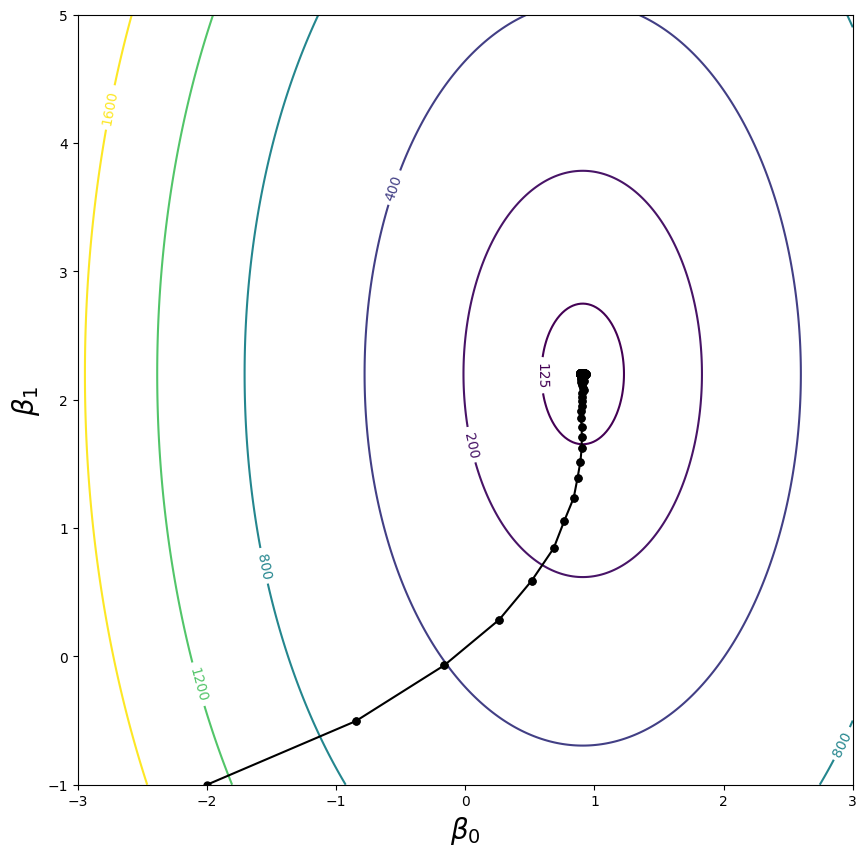

In [39]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part C**: Now that you have created this beautiful solver, go back and break it by playing with the learning rate. Does the learning rate have the effect on convergence that you expect when visualized in the surface plot? 

C:\Users\OM-FI\AppData\Local\Temp\ipykernel_21508\1799256422.py:26: RuntimeWarning: overflow encountered in scalar multiply
  beta = beta - eta * 2 * diff * X[index, :]
C:\Users\OM-FI\AppData\Local\Temp\ipykernel_21508\1799256422.py:26: RuntimeWarning: invalid value encountered in subtract
  beta = beta - eta * 2 * diff * X[index, :]


CPU times: total: 297 ms
Wall time: 305 ms
beta_0 = nan, beta_1 = nan eta = 0.8
CPU times: total: 297 ms
Wall time: 297 ms
beta_0 = 0.83450, beta_1 = 4.38019 eta = 0.4
CPU times: total: 297 ms
Wall time: 299 ms
beta_0 = 0.89345, beta_1 = 2.21049 eta = 0.04
CPU times: total: 281 ms
Wall time: 288 ms
beta_0 = 0.90911, beta_1 = 2.20318 eta = 0.002
CPU times: total: 281 ms
Wall time: 292 ms
beta_0 = 0.90891, beta_1 = 2.20093 eta = 0.0002
CPU times: total: 297 ms
Wall time: 298 ms
beta_0 = 0.85591, beta_1 = 1.37964 eta = 2e-05


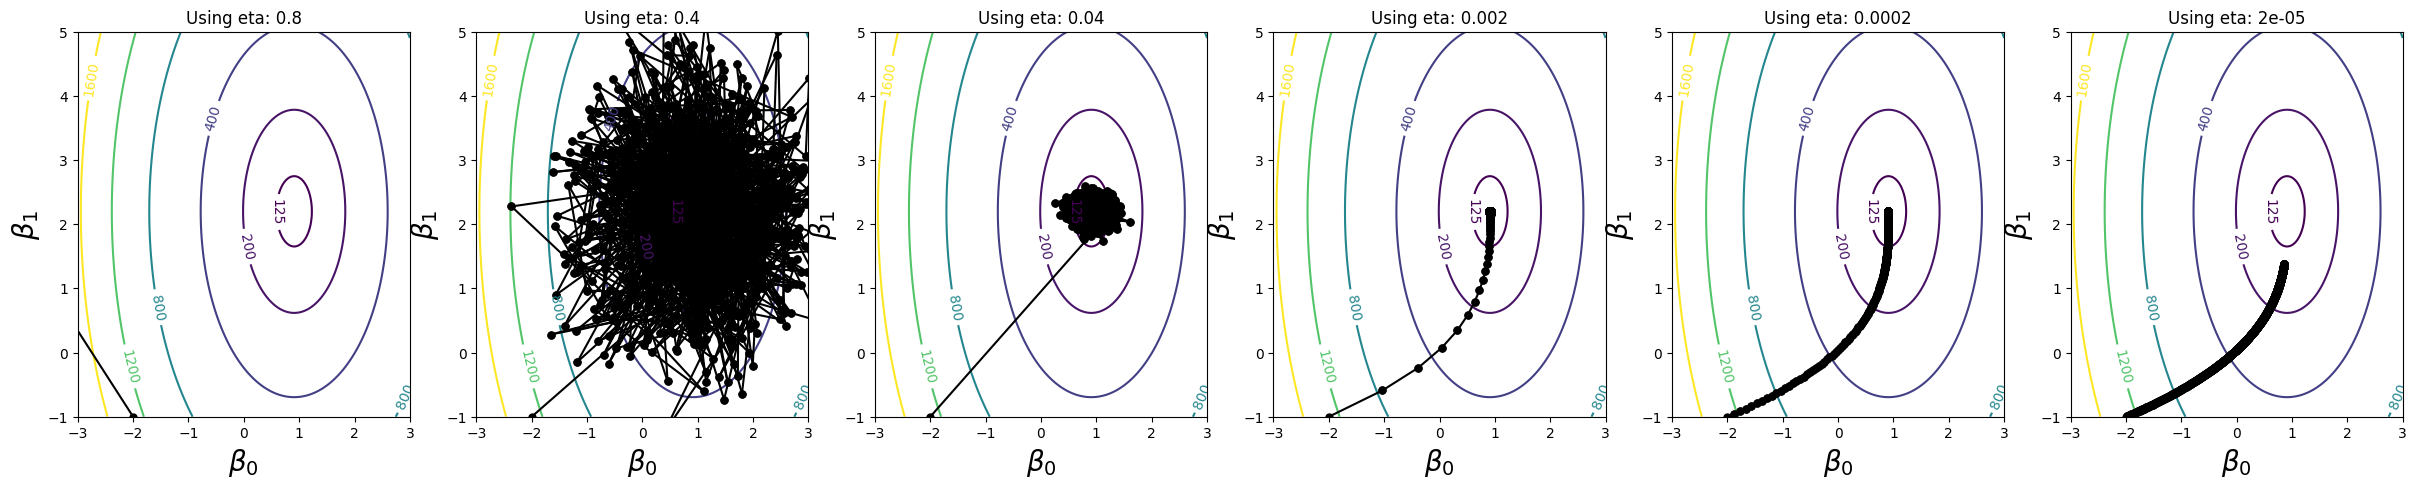

In [58]:
def plotsurface(X, y, eta, ax, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1]) ** 2
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0, y1], color="black", marker="o", lw=1.5, markersize=5)
    ax.set_title(f"Using eta: {eta}")

def compare_etas(etas):
    # Start at (-2,1)
    beta_start = np.array([-2.0, -1.0])

    # Training
    fig, axs = plt.subplots(nrows=1, ncols=len(etas), figsize=(30,5))
    for i, eta in enumerate(etas):
        ax = axs[i]  # Get the current subplot's axis
        %time bhist = sgd(X_train, y_train, beta=beta_start, eta=eta, num_epochs=1000)
        bhist = sgd(X_train, y_train, beta=beta_start, eta=eta, num_epochs=1000)
        # Print and Plot
        print("beta_0 = {:.5f}, beta_1 = {:.5f} eta = {}".format(bhist[-1][0], bhist[-1][1], eta))
        plotsurface(X_train, y_train, eta, ax, bhist=bhist)

compare_etas([0.8, 0.4, 0.04, 0.002, 0.0002, 0.00002])
plt.show()